In [2]:
import pandas as pd
import numpy as np
import sklearn as sk


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<h3>Data Preparation:</h3>

<h4>Definition der Dataframes:</h4>

Einlesen der Dateien als Dataframes aufgeteilt nach verschiedenen Sensoren (Accelerometer, Gyroscope, Orientation, Gravity)

Datenaufzeichnung mit Aktivitäten des alltäglichen Lebens: -> Aufteilung in einen Dataframe mit Label "df_walk"
- Laufen
- Treppe hoch
- Treppe runter
- auf Stuhl setzen
- Ins Bett legen

Fallen: (-> Aufteilung in einen Dataframe mit Label "df_fall")
- aus dem Laufen stürzen
- aus dem Stehen stürzen
- aus dem Sitzen stürzen



In [3]:
df_walk = pd.read_json("data/laufen_normal1.json") + pd.read_json("data/treppe_hoch1.json") + pd.read_json("data/treppe_runter1.json") + pd.read_json("data/bett_setzen1.json") + pd.read_json("data/hinsetzen1.json")

df_fall = pd.read_json("data/laufen_fall1.json") + pd.read_json("data/laufen_fall2.json") + pd.read_json("data/laufen_fall3.json") + pd.read_json("data/laufen_fall4.json") + pd.read_json("data/laufen_fall5.json") + pd.read_json("data/laufen_fall6.json") + pd.read_json("data/laufen_fall7.json") + pd.read_json("data/laufen_fall8.json") + pd.read_json("data/laufen_fall9.json") + pd.read_json("data/laufen_fall10.json")

Veranschaulichung exemplarischer Dataframes:

In [4]:
df_walk.describe()

,time,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,6.006000e+03,6.006000e+03,6005.000000,6005.000000,6005.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,8.425414e+18,-1.505268e+03,-0.964825,0.473038,1.083015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.849651e+13,4.849651e+04,1.713941,1.303116,1.690108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8.422443e+18,-2.972563e+06,-5.143768,-7.158063,-4.074336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.425416e+18,5.424619e+01,-2.279694,-0.303862,-0.071419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.425416e+18,7.610017e+01,-1.011620,0.468363,1.514297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.425416e+18,1.066668e+02,0.116132,1.384521,2.423218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.425416e+18,1.510111e+02,5.812659,6.345926,5.343290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Auswahl der relevanten Spalten/ Informationen aus dem Datensatz

In [5]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

Umrechnung der Zeit aus Sekunden in einen Zeitstempel:

In [6]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
#df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,AccelerometerAccelerometerAccelerometerAcceler...,2236-11-23 23:29:09.551869952,-2.972563e+06,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibratedAccelerometerUncalibr...,2236-12-28 09:11:52.532846592,5.184644e-02,-4.936050,-1.094238,0.432526,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibratedAccelerometerUncalibr...,2236-12-28 09:11:52.583166976,1.021667e-01,-5.139191,-0.982254,0.539459,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibratedAccelerometerUncalibr...,2236-12-28 09:11:52.633487360,1.524871e-01,-5.143768,-0.920166,0.540375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibratedAccelerometerUncalibr...,2236-12-28 09:11:52.683806720,2.028066e-01,-4.765320,-0.884232,0.772430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index als Zeitstempel definiert:

In [7]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
#df_testFall = df_testFall.set_index('time')

Ausgabe aller Sensoren, die in Datensatz vorhanden sind:

In [8]:
df_walk['sensor'].unique()

array(['AccelerometerAccelerometerAccelerometerAccelerometerAccelerometer',
       'AccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGravityAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGyroscopeAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGyroscopeUncalibratedAccelerometerUncalibratedAccelerometerUncalibrated',
       'GravityAccelerometerUncalibratedGyroscopeUncalibratedAccelerometerUncalibratedGravity',
       'GyroscopeAccelerometerUncalibratedGyroscopeUncalibratedAccelerometerUncalibratedGyroscope',
       'GyroscopeUncalibratedAccelerometerUncalibratedGyroscopeUncalibratedAccelerometerUncalibratedGyroscopeUncalibrated',
       'GyroscopeUncalibratedGravityGyroscopeUncalibratedAccelerometerUncalibratedGyroscopeUncalib

In [9]:
df_fall['sensor'].unique()

array(['AccelerometerAccelerometerAccelerometerAccelerometerAccelerometerAccelerometerAccelerometerAccelerometerAccelerometerAccelerometer',
       'AccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGravityAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGyroscopeAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibratedAccelerometerUncalibrated',
       'AccelerometerUncalibratedAccelerometerUncalibratedGyroscopeUncalibratedAccelerometerUncalibratedAccele

Aufteilung der Daten nach den zu betrachtenden Sensoren:

In [10]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']
df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

df_walk_gyro = df_walk[df_walk['sensor'] == 'GyroscopeUncalibrated']
df_fall_gyro = df_fall[df_fall['sensor'] == 'GyroscopeUncalibrated']
df_testFall_gyro = df_testFall[df_testFall['sensor'] == 'GyroscopeUncalibrated']

df_walk_or = df_walk[df_walk['sensor'] == 'Orientation']
df_fall_or = df_fall[df_fall['sensor'] == 'Orientation']
df_testFall_or = df_testFall[df_testFall['sensor'] == 'Orientation']


NameError: name 'df_testFall' is not defined

Beschreiben des Datensatzes:

In [ ]:
df_fall_or.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Auswahl der relevanten Spalten aus den Dataframes der nach Sensordaten:

-> Hier wurden die Werte z,x,y aus den Gyro Sensoren in z_ umbenannt, um später für den join der Tabellen eindeutige Spalten zu erzeugen

In [ ]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]
df_testFall_acc = df_testFall_acc[['z','x','y']]

df_walk_gyro = df_walk_gyro[['z','x','y']]
df_fall_gyro = df_fall_gyro[['z','x','y']]
df_testFall_gyro = df_testFall_gyro[['z','x','y']]

df_walk_or = df_walk_or[['qx','qz','qw','qy']]
df_fall_or = df_fall_or[['qx','qz','qw','qy']]
df_testFall_or = df_testFall_or[['qx','qz','qw','qy']]

df_walk_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)
df_fall_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)


Plot der Dataframes zur Kontrolle und Veranschaulichung der Werte:

<Axes: xlabel='time'>

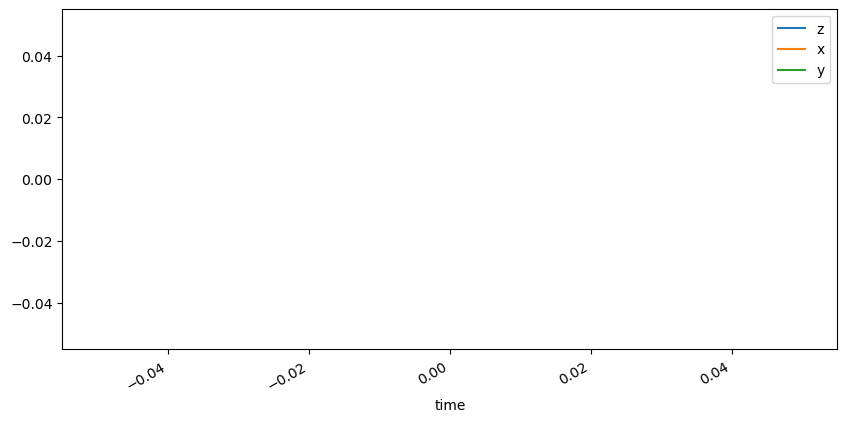

In [ ]:
df_walk_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

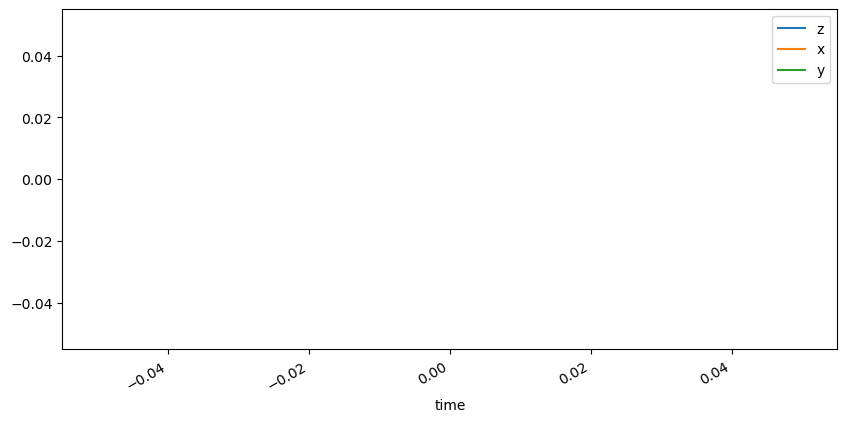

In [ ]:
df_fall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

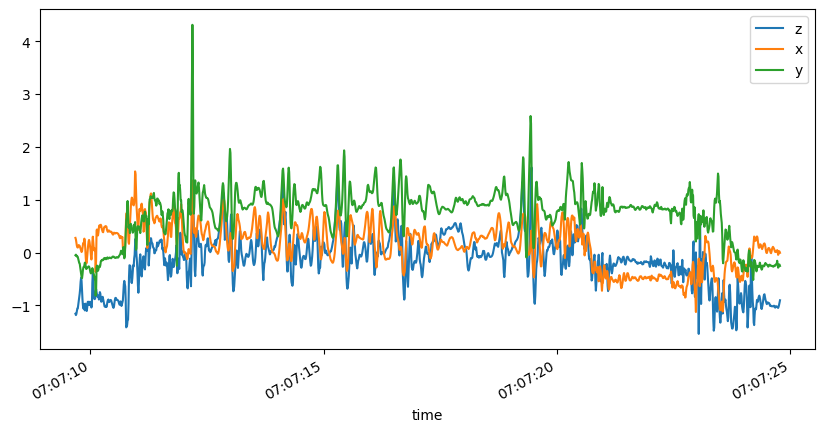

In [ ]:
df_testFall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

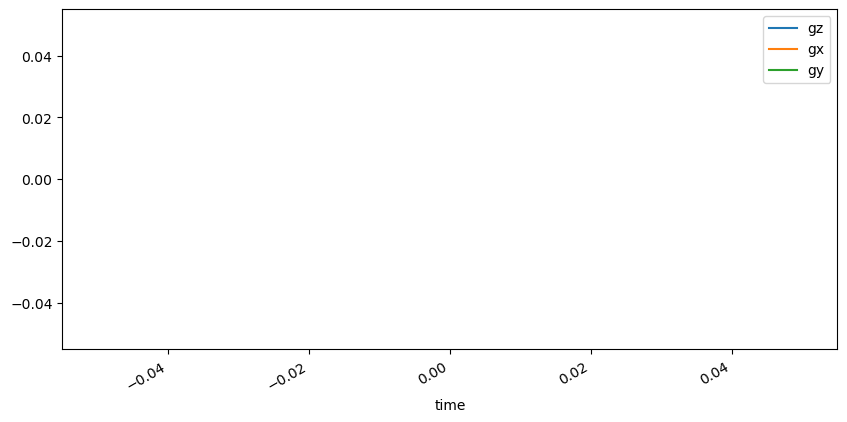

In [ ]:
df_walk_gyro.plot(figsize=(10,5))

<Axes: xlabel='time'>

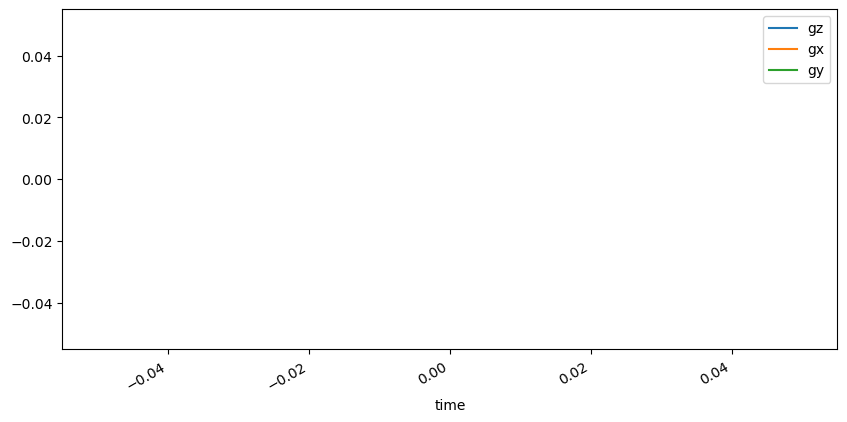

In [ ]:
df_fall_gyro.plot(figsize=(10,5))

Vergabe von Labels auf der Basis des Dataframe Ursprungs (Einteilung in Walk und Fall):

-> Verbinden der verschiedenen DataFrames nach Sensoren zu einem kombinierten Dataframe

In [ ]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_walk_gyro['label'] = "walk"
df_fall_gyro['label'] = "fall"

df_walk_or['label'] = "walk"
df_fall_or['label'] = "fall"

df_testFall_acc['label'] = "fall"
df_testFall_gyro['label'] = "fall"
df_testFall_or['label'] = "fall"

df_combined_walk = pd.merge(df_walk_acc, df_walk_gyro, on='time')
df_combined_fall = pd.merge(df_fall_acc, df_fall_gyro, on='time')

Check der kombinierten DataFrames:

In [ ]:
df_combined_walk.describe()

,z,x,y,gz,gx,gy
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_combined_fall.head(-5)

,z,x,y,label_x,gz,gx,gy,label_y
time,,,,,,,,


Bestimmung der Länge der Datensätze:

In [ ]:
df_help = df_combined_walk.reset_index()
print(df_help.iloc[-1,0] - df_help.iloc[0,0])

IndexError: index -1 is out of bounds for axis 0 with size 0

Ausschluss der Spalte "label_x" da redundant: 

In [ ]:
df_combined_walk.drop('label_x',axis=1, inplace=True)
df_combined_fall.drop('label_x',axis=1, inplace=True)

Überprüfen der Vollständigkeit des Datensatzes:

In [ ]:
laenge = len(df_walk_acc) + len(df_walk_gyro)
print("Doppelte Zeilen in Dataframes, ohne join auf Time:", laenge)
print("Einfache Anzahl an Zeilen, bei richtigem Merge:",len(df_combined_walk))
print("Länge des Merges:", len(df_combined_walk))

Doppelte Zeilen in Dataframes, ohne join auf Time: 15602
Einfache Anzahl an Zeilen, bei richtigem Merge: 7801
Länge des Merges: 7801


Aufteilen der DF's in einzelne Abschnitte mit den Abständen 100 Datenpunkte:
- ToDo: Anpassen der Länge von Sequenzen und deren Auswirkung auf die Modellgüte/ Accuracy

In [ ]:
df_combined_walk['id'] = 0
df_combined_fall['id'] = 0

id = 1

var1 = 100
var2 = 100

for i in range(0, len(df_combined_walk)):
    df_combined_walk.iloc[i,7] = id
    

    if i >= var1: 
        var1 = var1 + 100
        id+=1
    
for i in range(0, len(df_combined_fall)):
    
    df_combined_fall.iloc[i,7] = id

    if i >= var2: 
        var2 = var2 + 100
        id+=1  

In [ ]:
df_combined_walk

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1
...,...,...,...,...,...,...,...,...
2023-05-05 06:59:56.610012928,-0.848389,0.046661,-0.506805,0.156614,-0.159282,0.041310,walk,78
2023-05-05 06:59:56.620076800,-0.861221,0.055542,-0.488983,0.198738,-0.107488,-0.042373,walk,78
2023-05-05 06:59:56.630141952,-0.900436,0.041672,-0.465683,0.213338,0.035620,-0.167855,walk,78


In [ ]:
df_combined_fall

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 07:00:05.796345344,-0.858704,-0.043808,-0.510193,-0.107170,0.143945,0.668648,fall,79
2023-05-05 07:00:05.806409472,-0.895935,-0.021576,-0.511230,-0.108921,0.115393,0.904805,fall,79
2023-05-05 07:00:05.816474368,-0.902679,0.091705,-0.473236,0.010160,0.078004,1.210142,fall,79
2023-05-05 07:00:05.826539264,-0.914108,0.206802,-0.422516,0.160927,0.132769,1.255230,fall,79
2023-05-05 07:00:05.836603392,-0.835724,0.232285,-0.367661,0.297366,0.192376,1.384964,fall,79
...,...,...,...,...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,-0.561477,0.103614,-0.864238,fall,109
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,-0.470264,0.181803,-0.671422,fall,109
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,-0.320177,0.209357,-0.403196,fall,109


Konkatenieren der verschiedenen Dataframes zu einem gemeinsamen DF:

In [ ]:
df_combined = pd.concat([df_combined_walk, df_combined_fall])

In [ ]:
df_combined

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1
...,...,...,...,...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,-0.561477,0.103614,-0.864238,fall,109
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,-0.470264,0.181803,-0.671422,fall,109
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,-0.320177,0.209357,-0.403196,fall,109


Check auf Nullwerte:

In [ ]:
df_combined.isnull().sum()

z          0
x          0
y          0
gz         0
gx         0
gy         0
label_y    0
id         0
dtype: int64

In [ ]:
df_combined.reset_index(inplace=True)
df_combined.head()

,time,z,x,y,gz,gx,gy,label_y,id
0,2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
1,2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2,2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
3,2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
4,2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1


In [ ]:
df_combined.replace(['walk'],0,inplace=True)
df_combined.replace(['fall'],1,inplace=True)
df_combined.head()

,time,z,x,y,gz,gx,gy,label_y,id
0,2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,0,1
1,2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,0,1
2,2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,0,1
3,2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,0,1
4,2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,0,1


Berechnen der extracted_features mit tsfresh: 

from tsfresh import extract_features
extracted_features = extract_features(df_combined, column_id="id",column_sort='time')

Ausgeben der errechneten Features mittels TsFresh:

In [ ]:
extracted_features

,z__variance_larger_than_standard_deviation,z__has_duplicate_max,z__has_duplicate_min,z__has_duplicate,z__sum_values,z__abs_energy,z__mean_abs_change,z__mean_change,z__mean_second_derivative_central,z__median,...,label_y__fourier_entropy__bins_5,label_y__fourier_entropy__bins_10,label_y__fourier_entropy__bins_100,label_y__permutation_entropy__dimension_3__tau_1,label_y__permutation_entropy__dimension_4__tau_1,label_y__permutation_entropy__dimension_5__tau_1,label_y__permutation_entropy__dimension_6__tau_1,label_y__permutation_entropy__dimension_7__tau_1,label_y__query_similarity_count__query_None__threshold_0.0,label_y__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,-93.162186,86.228242,0.018815,-0.001584,0.000305,-0.928360,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,-89.148010,81.172102,0.031519,-0.000580,-0.000823,-0.877502,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,-73.498352,91.606258,0.226267,0.009452,-0.000332,-0.773949,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,-7.005432,3.531542,0.079094,-0.001733,0.000146,-0.064857,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,8.843323,5.324660,0.036011,0.006891,0.000309,0.029686,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.0,1.0,-35.633606,12.698285,0.001786,-0.000071,-0.000018,-0.356194,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
106,0.0,0.0,0.0,1.0,-34.770935,12.280162,0.009576,0.001070,0.000181,-0.357529,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
107,0.0,0.0,0.0,0.0,23.019043,11.751855,0.024704,0.007959,0.000034,0.289558,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
108,0.0,0.0,0.0,1.0,58.027222,34.479675,0.040497,-0.001848,-0.000365,0.586349,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0


In [ ]:
labels= df_combined[['id','label_y']]
labels= labels.drop_duplicates()
labels= labels.set_index('id')
y= labels.iloc[:,0]
print(y)


id
1      0
2      0
3      0
4      0
5      0
      ..
105    1
106    1
107    1
108    1
109    1
Name: label_y, Length: 109, dtype: int64


ACHTUNG: select_features vs. extract_relevant_features Unterschied ermitteln, Recherche

Features_filtered wird nicht weiter benutzt

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
#test
impute(extracted_features)
features_filtered = select_features(extracted_features,y)

In [ ]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df_combined, y,
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


features_filtered.columns

In [ ]:
features_filtered_direct.columns

Index(['label_y__count_below__t_0',
       'label_y__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)',
       ...
       'label_y__range_count__max_1__min_-1', 'label_y__value_count__value_0',
       'z__permutation_entropy__dimension_7__tau_1',
       'gz__ratio_beyond_r_sigma__r_3',
       'z__permutation_entropy__dimension_6__tau_1',
       'z__permutation_entropy__dimension_5__tau_1',
       'z__permuta

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered_direct, y, test_size=0.30, random_state=101)

In [ ]:
y_test

id
86     1
26     0
103    1
33     0
109    1
17     0
2      0
51     0
48     0
49     0
32     0
56     0
14     0
99     1
62     0
85     1
46     0
22     0
72     0
7      0
91     1
68     0
95     1
15     0
55     0
83     1
90     1
54     0
4      0
59     0
47     0
44     0
58     0
Name: label_y, dtype: int64

In [ ]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [ ]:
#Test via Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24  0]
 [ 0  9]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#randomforest
rf= RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

#Test via Konfusionsmatrix
dm = confusion_matrix(y_test, y_pred)
print(dm)

[[24  0]
 [ 0  9]]
